# Particle Pitch Angle Distribution
author: Louis Richard\
Calculate and plot electron and ion pitch angle distributions from particle brst data.

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from pyrfu import mms
from pyrfu.plot import plot_line, plot_spectr, make_labels

Load IGRF coefficients ...


## Define spacecraft index, data path and time interval

In [2]:
ic = 3  # Spacecraft number
mms.db_init("/Volumes/mms")
tint = ["2015-10-30T05:15:20.000", "2015-10-30T05:16:20.000"]

## Load Data

### Particle distributions

In [3]:
# vdf_i = mms.get_data("pdi_fpi_brst_l2", tint, ic)
vdf_i, vdf_e = [mms.get_data(f"pd{s}_fpi_brst_l2", tint, ic) for s in ["i", "e"]]

09-Dec-21 11:42:10: Loading mms3_dis_dist_brst...
09-Dec-21 11:42:15: Loading mms3_des_dist_brst...


### Particle energy fluxes

In [4]:
def_omni_i, def_omni_e = [mms.get_data(f"def{s}_fpi_brst_l2", tint, ic) for s in ["i", "e"]]

09-Dec-21 11:42:27: Loading mms3_dis_energyspectr_omni_brst...
09-Dec-21 11:42:30: Loading mms3_des_energyspectr_omni_brst...


### Particle moments

In [5]:
n_i, n_e = [mms.get_data(f"n{s}_fpi_brst_l2", tint, ic) for s in ["i", "e"]]
v_xyz_i, v_xyz_e = [mms.get_data(f"v{s}_gse_fpi_brst_l2", tint, ic) for s in ["i", "e"]]
t_xyz_i, t_xyz_e = [mms.get_data(f"t{s}_gse_fpi_brst_l2", tint, ic) for s in ["i", "e"]]

09-Dec-21 11:42:33: Loading mms3_dis_numberdensity_brst...
09-Dec-21 11:42:35: Loading mms3_des_numberdensity_brst...
09-Dec-21 11:42:36: Loading mms3_dis_bulkv_gse_brst...
09-Dec-21 11:42:40: Loading mms3_des_bulkv_gse_brst...
09-Dec-21 11:42:45: Loading mms3_dis_temptensor_gse_brst...
09-Dec-21 11:42:52: Loading mms3_des_temptensor_gse_brst...


### Other variables

In [6]:
b_xyz, b_gse = [mms.get_data(f"b_{cs}_fgm_brst_l2", tint, ic) for cs in ["dmpa", "gse"]]
scpot = mms.get_data("v_edp_brst_l2", tint, ic)

09-Dec-21 11:42:59: Loading mms3_fgm_b_dmpa_brst_l2...
09-Dec-21 11:43:00: Loading mms3_fgm_b_gse_brst_l2...
09-Dec-21 11:43:02: Loading mms3_edp_scpot_brst_l2...


### Compute parallel and perpendicular electron and ion temperatures

In [7]:
t_fac_i, t_fac_e = [mms.rotate_tensor(t_xyz, "fac", b_xyz, "pp") for t_xyz in [t_xyz_i, t_xyz_e]]

t_para_i, t_para_e = [t_fac[:, 0, 0] for t_fac in [t_fac_i, t_fac_e]]
t_perp_i, t_perp_e = [t_fac[:, 1, 1] for t_fac in [t_fac_i, t_fac_e]]

09-Dec-21 11:43:03: /opt/anaconda3/lib/python3.8/site-packages/pyrfu/pyrf/resample.py:177: UserWarning: Using averages in resample
  warnings.warn("Using averages in resample", UserWarning)



notice : Transforming tensor into field-aligned coordinates.
notice : Rotating tensor so perpendicular diagonal components are equal.
notice : Transforming tensor into field-aligned coordinates.
notice : Rotating tensor so perpendicular diagonal components are equal.


## Compute pitch-angle distributions

### Rebin VDFs to 64 energy channels

In [8]:
vdf_e64_i, vdf_e64_e = [mms.vdf_to_e64(vdf) for vdf in [vdf_i, vdf_e]]

### Electron and ion pitch angle distribution

In [9]:
pad_i, pad_e = [mms.get_pitch_angle_dist(vdf, b_xyz, tint, angles=n) for vdf, n in zip([vdf_e64_i, vdf_e64_e], [18, 24])]

notice : User defined number of pitch angles.


09-Dec-21 11:43:06: /opt/anaconda3/lib/python3.8/site-packages/pyrfu/pyrf/resample.py:177: UserWarning: Using averages in resample
  warnings.warn("Using averages in resample", UserWarning)



notice : User defined number of pitch angles.


### PSD -> DEF

In [10]:
pad_def_i, pad_def_e = [mms.psd2def(pad) for pad in [pad_i, pad_e]]

### Split in low energy, middle energy and high energy groups

In [11]:
def split_energy(pad, idx):
    coords = [pad.time.data, pad.theta.data[0, :]]
    dims = ["time", "theta"]
    pad_lowen = xr.DataArray(np.nanmean(pad.data[:, :idx[0], :], axis=1), coords=coords, dims=dims)
    pad_miden = xr.DataArray(np.nanmean(pad.data[:, idx[0]:idx[1], :], axis=1), coords=coords, dims=dims)
    pad_higen = xr.DataArray(np.nanmean(pad.data[:, idx[1]:, :], axis=1), coords=coords, dims=dims)
    
    energy = pad.energy.data[0, :]
    e_int = {"lowen": "{:6.2f} eV - {:6.2f} eV".format(energy[0], energy[idx[0] - 1]),
            "miden": "{:6.2f} eV - {:6.2f} eV".format(energy[idx[0]], energy[idx[1] - 1]),
            "higen": "{:6.2f} eV - {:6.2f} eV".format(energy[idx[1]], energy[-1])}
    return pad_lowen, pad_miden, pad_higen, e_int

pad_lowen_i, pad_miden_i, pad_higen_i, e_int_i = split_energy(pad_def_i, [21, 42])
pad_lowen_e, pad_miden_e, pad_higen_e, e_int_e = split_energy(pad_def_e, [21, 42])

09-Dec-21 11:43:35: <ipython-input-11-41cf3afaeb44>:4: RuntimeWarning: Mean of empty slice
  pad_lowen = xr.DataArray(np.nanmean(pad.data[:, :idx[0], :], axis=1), coords=coords, dims=dims)

09-Dec-21 11:43:35: <ipython-input-11-41cf3afaeb44>:5: RuntimeWarning: Mean of empty slice
  pad_miden = xr.DataArray(np.nanmean(pad.data[:, idx[0]:idx[1], :], axis=1), coords=coords, dims=dims)

09-Dec-21 11:43:35: <ipython-input-11-41cf3afaeb44>:6: RuntimeWarning: Mean of empty slice
  pad_higen = xr.DataArray(np.nanmean(pad.data[:, idx[1]:, :], axis=1), coords=coords, dims=dims)



## Plot

In [12]:
legend_options = dict(frameon=True, loc="upper right", ncol=3)

### Plot Ion data

<IPython.core.display.Javascript object>


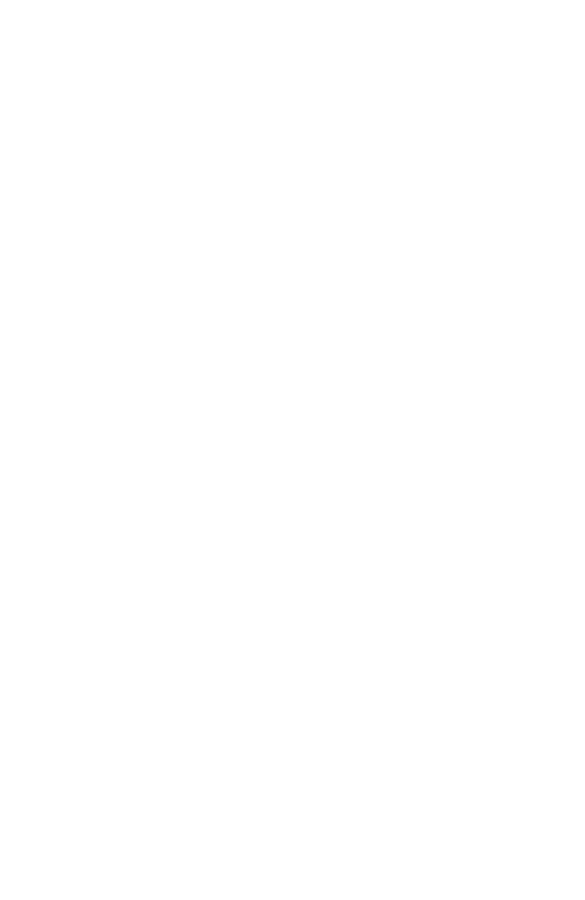

In [13]:
%matplotlib notebook
f, axs = plt.subplots(7, sharex="all", figsize=(6.5, 10))
f.subplots_adjust(bottom=.1, top=.95, left=.15, right=.85, hspace=0)

plot_line(axs[0], b_xyz)
axs[0].set_ylabel("$B_{DMPA}$" + "\n" + "[nT]")
axs[0].legend(["$B_{x}$", "$B_{y}$", "$B_{z}$"], **legend_options)

plot_line(axs[1], n_i)
axs[1].set_ylabel("$n_{i}$" + "\n" + "[cm$^{-3}$]")

plot_line(axs[2], v_xyz_i)
axs[2].set_ylabel("$V_{i}$" + "\n" + "[km s$^{-1}$]")
axs[2].legend(["$V_{x}$", "$V_{y}$", "$V_{z}$"], **legend_options)

axs[3], caxs3 = plot_spectr(axs[3], def_omni_i, yscale="log", cscale="log", cmap="Spectral_r")
plot_line(axs[3], t_para_i)
plot_line(axs[3], t_perp_i)
axs[3].set_ylabel("$E_i$" + "\n" + "[eV]")
caxs3.set_ylabel("DEF" + "\n" + "[kev/(cm$^2$ s sr keV)]")
axs[3].legend(["$T_{||}$","$T_{\perp}$"], **legend_options)

axs[4], caxs4 = plot_spectr(axs[4], pad_lowen_i, cscale="log", cmap="Spectral_r")
axs[4].set_ylabel("$\\theta$" + "\n" + "[$^\\circ$]")
caxs4.set_ylabel("DEF" + "\n" + "[kev/(cm$^2$ s sr keV)]")
axs[4].text(0.05, 0.1, e_int_i["lowen"], transform=axs[4].transAxes)

axs[5], caxs5 = plot_spectr(axs[5], pad_miden_i, cscale="log", cmap="Spectral_r")
axs[5].set_ylabel("$\\theta$" + "\n" + "[$^\\circ$]")
caxs5.set_ylabel("DEF" + "\n" + "[kev/(cm$^2$ s sr keV)]")
axs[5].text(0.05, 0.1, e_int_i["miden"], transform=axs[5].transAxes)

axs[6], caxs6 = plot_spectr(axs[6], pad_higen_i, cscale="log", cmap="Spectral_r")
axs[6].set_ylabel("$\\theta$" + "\n" + "[$^\\circ$]")
caxs6.set_ylabel("DEF" + "\n" + "[kev/(cm$^2$ s sr keV)]")
axs[6].text(0.05, 0.1, e_int_i["higen"], transform=axs[6].transAxes)

make_labels(axs, [0.02, 0.85])

f.align_ylabels(axs)

### Plot Electron data

<IPython.core.display.Javascript object>


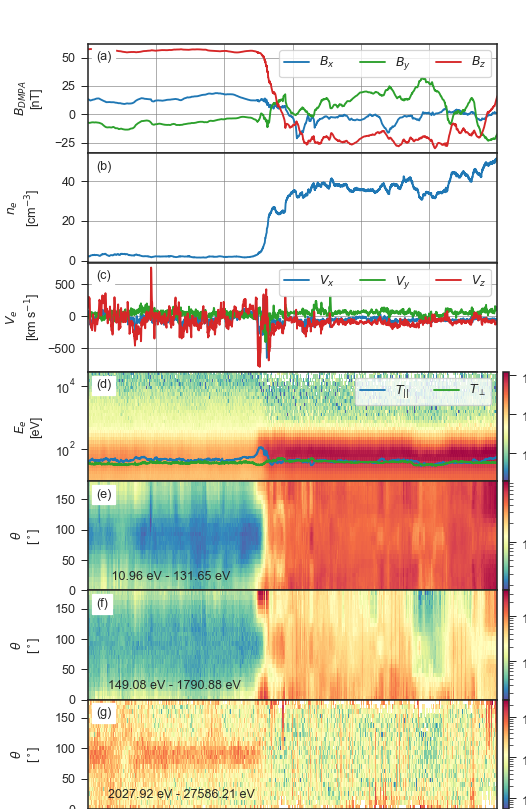

In [14]:
%matplotlib notebook
f, axs = plt.subplots(7, sharex="all", figsize=(6.5, 10))
f.subplots_adjust(bottom=.1, top=.95, left=.15, right=.85, hspace=0)

plot_line(axs[0], b_xyz)
axs[0].set_ylabel("$B_{DMPA}$" + "\n" + "[nT]")
axs[0].legend(["$B_{x}$", "$B_{y}$", "$B_{z}$"], **legend_options)

plot_line(axs[1], n_e)
axs[1].set_ylabel("$n_{e}$" + "\n" + "[cm$^{-3}$]")

plot_line(axs[2], v_xyz_e)
axs[2].set_ylabel("$V_{e}$" + "\n" + "[km s$^{-1}$]")
axs[2].legend(["$V_{x}$", "$V_{y}$", "$V_{z}$"], **legend_options)

axs[3], caxs3 = plot_spectr(axs[3], def_omni_e, yscale="log", cscale="log", cmap="Spectral_r")
plot_line(axs[3], t_para_e)
plot_line(axs[3], t_perp_e)
axs[3].set_ylabel("$E_e$" + "\n" + "[eV]")
caxs3.set_ylabel("DEF" + "\n" + "[kev/(cm$^2$ s sr keV)]")
axs[3].legend(["$T_{||}$","$T_{\perp}$"], **legend_options)

axs[4], caxs4 = plot_spectr(axs[4], pad_lowen_e, cscale="log", cmap="Spectral_r")
axs[4].set_ylabel("$\\theta$" + "\n" + "[$^\\circ$]")
caxs4.set_ylabel("DEF" + "\n" + "[kev/(cm$^2$ s sr keV)]")
axs[4].text(0.05, 0.1, e_int_e["lowen"], transform=axs[4].transAxes)

axs[5], caxs5 = plot_spectr(axs[5], pad_miden_e, cscale="log", cmap="Spectral_r")
axs[5].set_ylabel("$\\theta$" + "\n" + "[$^\\circ$]")
caxs5.set_ylabel("DEF" + "\n" + "[kev/(cm$^2$ s sr keV)]")
axs[5].text(0.05, 0.1, e_int_e["miden"], transform=axs[5].transAxes)

axs[6], caxs6 = plot_spectr(axs[6], pad_higen_e, cscale="log", cmap="Spectral_r")
axs[6].set_ylabel("$\\theta$" + "\n" + "[$^\\circ$]")
caxs6.set_ylabel("DEF" + "\n" + "[kev/(cm$^2$ s sr keV)]")
axs[6].text(0.05, 0.1, e_int_e["higen"], transform=axs[6].transAxes)

make_labels(axs, [0.02, 0.85])

f.align_ylabels(axs)